# 1. Analyze dataset

Load wine dataset and analyze it. The goal is to understand the features, their values and the labels.

In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

dataset = pd.read_csv('./datasets/winequality-white.csv',sep=';')

Wine dataset contains 11 numeric features and an integer label column (quality).

In [2]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


Although wine labels vary from 1-9, we only see 7 values. Therefore the labels that we have are only 7 - not 9.

In [3]:
print(f'Labels: {sorted(dataset.quality.unique())}')
print(f'Label count: {len(dataset.quality.unique())}')
print(f'Min label: {dataset.quality.min()}')
print(f'Max label: {dataset.quality.max()}')

Labels: [3, 4, 5, 6, 7, 8, 9]
Label count: 7
Min label: 3
Max label: 9


We see that the features have very different scales, and therefore it should be useful to scale them.

In [4]:
dataset.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


Also, a good thing is that the dataset does not contain null values.

In [5]:
dataset.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

We see that most of the wines have quality scores 5-9. There are no wines with quality less than 3 or equal to 10.

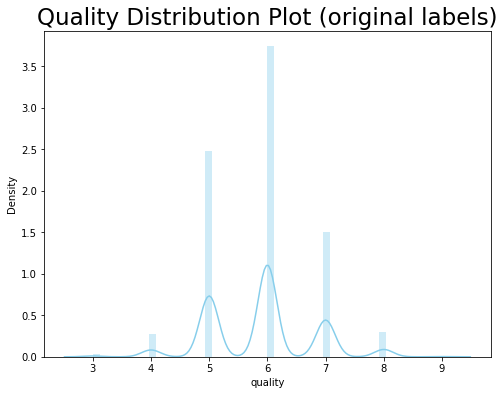

quality
3    0.004083
4    0.033279
5    0.297468
6    0.448755
7    0.179665
8    0.035729
9    0.001021
dtype: float64

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

_, _ = plt.subplots(figsize=(8, 6))
plt.title('Quality Distribution Plot (original labels)',fontsize=23)
sns.distplot(dataset['quality'], color='skyblue')
plt.show()

dataset.groupby('quality').size().groupby(level=0).apply(lambda row: row / len(dataset.index))

As we don't have a good distribution of labels, we will reduce their number. Let's try to reduce the labels' number to 3:
- 0 if quality is less or equal to 5
- 1 if quality is equal to 6
- 2 if quality is greater than 6.

We see that we have a much better distribution of wines to labels.

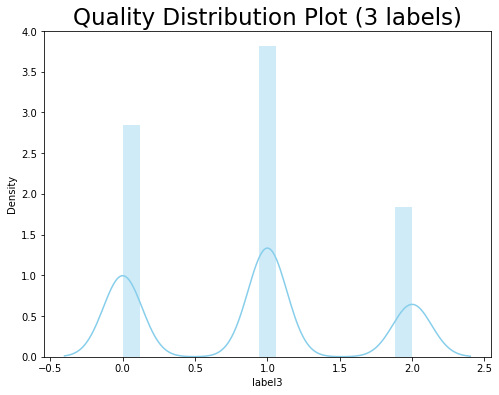

label3
0    0.334831
1    0.448755
2    0.216415
dtype: float64

In [7]:
dataset['label3'] = dataset.apply(lambda row: 0 if row['quality'] <=5 else (1 if row['quality'] == 6 else 2), axis=1)

_, _ = plt.subplots(figsize=(8, 6))
plt.title('Quality Distribution Plot (3 labels)',fontsize=23)
sns.distplot(dataset['label3'], color='skyblue')
plt.show()

dataset.groupby('label3').size().groupby(level=0).apply(lambda row: row / len(dataset.index))

Last but not least, let's try to reduce the label's number to 2:
- 0 if quality is less or equal to 5
- 1 if quality is greater or equal to 6

We see that we have a more uneven distribution. Maybe it is better to keep the 3 labels.

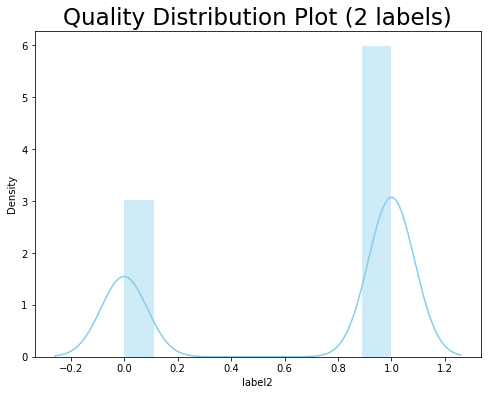

label2
0    0.334831
1    0.665169
dtype: float64

In [8]:
dataset['label2'] = dataset.apply(lambda row: 0 if row['quality'] <=5 else 1, axis=1)

_, _ = plt.subplots(figsize=(8, 6))
plt.title('Quality Distribution Plot (2 labels)',fontsize=23)
sns.distplot(dataset['label2'], color='skyblue')
plt.show()

dataset.groupby('label2').size().groupby(level=0).apply(lambda row: row / len(dataset.index))

# 2. Running kMeans and tuning hyperparameters
We will run kMeans with different values of k (1 - 30) and with different initialization methods (k-means++, random).\

In order to produce the best posible results, we will increase n_init parameter to perform more runs and select the ones with optimal errors.


First, we prepare the data for clustering.

In [9]:
from sklearn.preprocessing import StandardScaler


features = dataset.drop(['quality', 'label2', 'label3'], axis=1)
feature_names = features.columns
features = StandardScaler().fit_transform(features)
features = pd.DataFrame(features, columns=feature_names)

wine_labels_2 = dataset['label2']
wine_labels_3 = dataset['label3']
wine_labels_7 = dataset['quality']

Then we will perform grid search in order to find the appropriate k and init method for the kMeans algorithm.

We will evaluate kMeans performance using the following:
- The Elbow method
- Silhouette Score
- Homogenity / Completeness agains true labels for the case of 2, 3 and 7 labels.

In [19]:
from tqdm.notebook import tqdm
from time import time
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn import metrics

n_clusters_values = range(1, 31)
covariance_type_values = ['full', 'tied', 'diag', 'spherical']

progress_bar = tqdm(total=len(n_clusters_values) * len(covariance_type_values))
bic = {covariance_type:[] for covariance_type in covariance_type_values}
silhouette_score = {covariance_type:[] for covariance_type in covariance_type_values}
fit_time = {init:[] for init in covariance_type_values}
v_measure_score = {
    'labels_2': {covariance_type:[] for covariance_type in covariance_type_values},
    'labels_3': {covariance_type:[] for covariance_type in covariance_type_values},
    'labels_7': {covariance_type:[] for covariance_type in covariance_type_values},
}
homogeneity_score = {
    'labels_2': {covariance_type:[] for covariance_type in covariance_type_values},
    'labels_3': {covariance_type:[] for covariance_type in covariance_type_values},
    'labels_7': {covariance_type:[] for covariance_type in covariance_type_values},
}
completeness_score = {
    'labels_2': {covariance_type:[] for covariance_type in covariance_type_values},
    'labels_3': {covariance_type:[] for covariance_type in covariance_type_values},
    'labels_7': {covariance_type:[] for covariance_type in covariance_type_values},
}
for covariance_type in covariance_type_values:
    for n_components in n_clusters_values:
        results = {}
        em = GaussianMixture(n_components=n_components,
                        covariance_type=covariance_type, random_state=42)
        t0 = time()
        em.fit(features)
        fit_time[covariance_type].append(time() - t0)
        labels_ = em.predict(features)
        bic[covariance_type].append(em.bic(features))
        silhouette_score[covariance_type].append(None if n_components == 1 else metrics.silhouette_score(features,
                                                                                            labels_,
                                                                                            metric="euclidean",
                                                                                            sample_size=300))
        v_measure_score['labels_2'][covariance_type].append(metrics.v_measure_score(
            wine_labels_2, labels_))
        v_measure_score['labels_3'][covariance_type].append(metrics.v_measure_score(
            wine_labels_3, labels_))
        v_measure_score['labels_7'][covariance_type].append(metrics.v_measure_score(
            wine_labels_7, labels_))
        homogeneity_score['labels_2'][covariance_type].append(metrics.homogeneity_score(
            wine_labels_2, labels_))
        homogeneity_score['labels_3'][covariance_type].append(metrics.homogeneity_score(
            wine_labels_3, labels_))
        homogeneity_score['labels_7'][covariance_type].append(metrics.homogeneity_score(
            wine_labels_7, labels_))
        completeness_score['labels_2'][covariance_type].append(metrics.completeness_score(
            wine_labels_2, labels_))
        completeness_score['labels_3'][covariance_type].append(metrics.completeness_score(
            wine_labels_3, labels_))
        completeness_score['labels_7'][covariance_type].append(metrics.completeness_score(
            wine_labels_7, labels_))
        progress_bar.update(1)

  0%|          | 0/120 [00:00<?, ?it/s]

In [20]:
def plot_clustering_metrics(ax, title, y_axis, x_axis, values, n_clusters_values):
    ax.set_xticks(n_clusters_values)
    for key in values:
        ax.plot(n_clusters_values, values[key])
    ax.set_title(title)
    ax.set(xlabel=x_axis, ylabel=y_axis)
    ax.grid()
    ax.legend(values.keys())

### Selecting the initialization method
As expected, selecting initial centroids using the k-means++ method (as described by Arthur, D. and Vassilvitskii, S. in “k-means++: the advantages of careful seeding paper) did not have any effect in performance. However, the results that I received were in contrast with the ones described in the paper. I did not see any improvement in the performance of the kMeans algorithm. On the contrast, random inialization had lower fit times. I am not aware why this happened. It could be the case that the wine dataset is too small and the performance uplift cannot exceed the k-means++ overhead cost and therefore the total fit time is worse, when compared to random centroid initialization.


### Selectintg the right cluster number
1. The Elbow Method: There is a clear "elbow" in the graph, which indicates k=2,3,4 as the best cluste values. Why? Because we see that the squared error of the distances of the points from their cluster center rapidly decreases until k=4. After k=4 the error still decreases, however, at a slow pace. Therefore, it seems that it does not worth to increase the cluster number further as the benefit in error reduction is negligible.
2. The Silhouette Score: I did not expect the results I got from the silhouette score: the score decreases as the number of clusters increases. Silhouette score represents how far is each point from the points of the same cluster vs how far it is from the points of all other clusters. This means that as the clusters increase, the selectd points cannot form clear groups. The best performing silhouette values are for k=2 (~0.5), k=3,4 (~0.4). After k=4 silhouette score drops significantly.

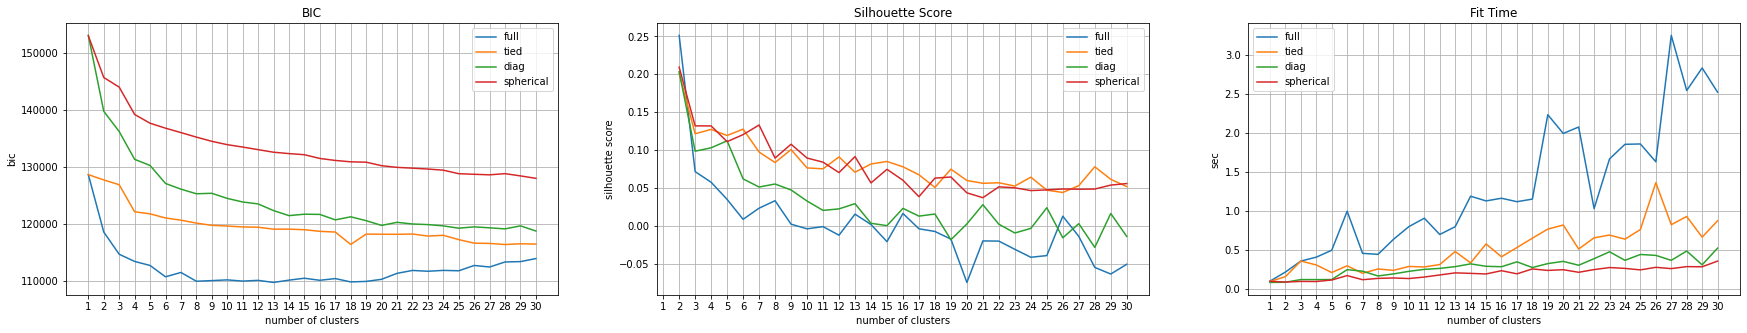

In [21]:
_, ax = plt.subplots(1, 3, figsize=(30, 5))
plot_clustering_metrics(ax[0], 'BIC', 'bic', 'number of clusters', bic, n_clusters_values)
plot_clustering_metrics(ax[1], 'Silhouette Score', 'silhouette score', 'number of clusters', silhouette_score, n_clusters_values)
plot_clustering_metrics(ax[2], 'Fit Time', 'sec', 'number of clusters', fit_time, n_clusters_values)

In [24]:
EM_COVARIANCE_TYPE = 'full'

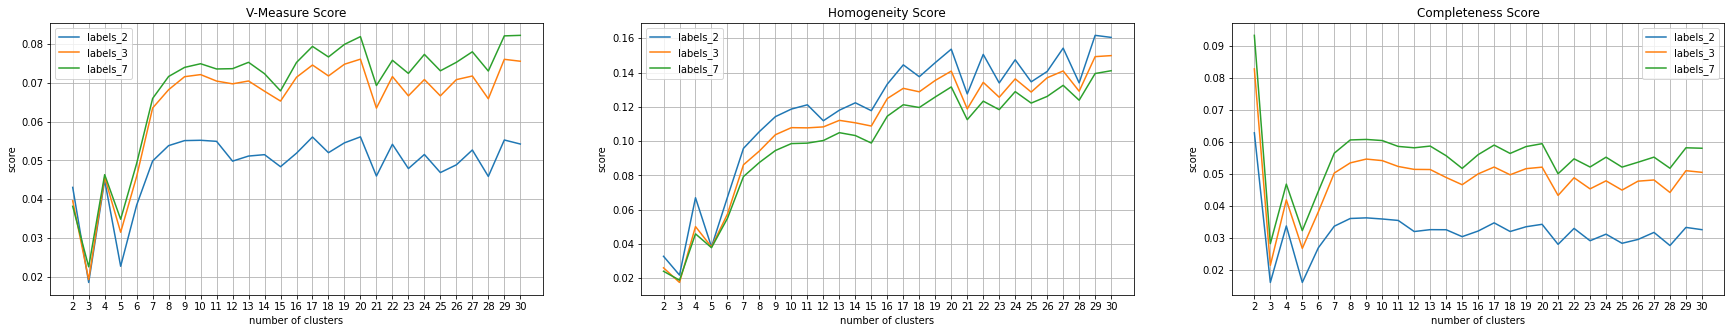

In [25]:
v_measure_score_plot = {label:v_measure_score[label][EM_COVARIANCE_TYPE][1:] for label in v_measure_score.keys()}
homogeneity_score_plot = {label:homogeneity_score[label][EM_COVARIANCE_TYPE][1:] for label in homogeneity_score.keys()}
completeness_score_plot = {label:completeness_score[label][EM_COVARIANCE_TYPE][1:] for label in completeness_score.keys()}
_, ax = plt.subplots(1, 3, figsize=(30, 5))
plot_clustering_metrics(ax[0], 'V-Measure Score', 'score', 'number of clusters', v_measure_score_plot, n_clusters_values[1:])
plot_clustering_metrics(ax[1], 'Homogeneity Score', 'score', 'number of clusters', homogeneity_score_plot, n_clusters_values[1:])
plot_clustering_metrics(ax[2], 'Completeness Score', 'score', 'number of clusters', completeness_score_plot, n_clusters_values[1:])

In [38]:
EM_CLUSTERS = 7

In [39]:
PCA_COMPONENTS = 8
ICA_COMPONENTS = 8
RANDOM_PROJECTION_COMPONENTS = 8
ENSEMBLE_IMPORTANT_FEATURES = ['volatile acidity',
   'citric acid',
   'residual sugar',
   'chlorides',
   'free sulfur dioxide',
   'density',
   'alcohol']

In [41]:
from sklearn.decomposition import FastICA, PCA
from sklearn.random_projection import SparseRandomProjection

pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
pca_features = pca.fit_transform(features)
ica = FastICA(n_components=ICA_COMPONENTS, whiten=True, random_state=42)
ica_features = ica.fit_transform(features)
rp = SparseRandomProjection(
    n_components=RANDOM_PROJECTION_COMPONENTS, random_state=42)
rp_features = rp.fit_transform(features)
important_features = features[ENSEMBLE_IMPORTANT_FEATURES].values

transformed_features_list = [features.values, pca_features,
                             ica_features, rp_features, important_features]

feature_count = [len(f[0]) for f in transformed_features_list]
fit_time = np.zeros(len(transformed_features_list))
bic = []
v_measure_score = []
silhouette_score = []
homogeneity_score = []
completeness_score = []
TIME_TESTS = 20
progress_bar = tqdm(total=len(transformed_features_list) * TIME_TESTS)
clustering_labels = []
for iteration in range(TIME_TESTS):
    for index, transformed_features in enumerate(transformed_features_list):
        em = GaussianMixture(n_components=EM_CLUSTERS,
                        covariance_type=EM_COVARIANCE_TYPE, random_state=42)
        t0 = time()
        em.fit(transformed_features)
        labels_ = em.predict(transformed_features)
        clustering_labels.append(labels_)
        fit_time[index] += time() - t0
        if iteration == 0:
            bic.append(em.bic(transformed_features))
            silhouette_score.append(metrics.silhouette_score(features,
                                                                labels_,
                                                                metric="euclidean",
                                                                sample_size=300))
            v_measure_score.append(metrics.v_measure_score(
                wine_labels_2, labels_))

            homogeneity_score.append(metrics.homogeneity_score(
                wine_labels_2, labels_))

            completeness_score.append(metrics.completeness_score(
                wine_labels_2, labels_))
        progress_bar.update(1)

fit_time = np.divide(fit_time, TIME_TESTS)


  0%|          | 0/100 [00:00<?, ?it/s]

In [43]:
em_metrics = pd.DataFrame(
    {
        'number of components': feature_count,
        'fit time': fit_time,
        'bic': bic,
        'silhouette score': silhouette_score,
        'v measure score': v_measure_score,
        'homogeneity score': homogeneity_score,
        'completeness score': completeness_score,
    },
    index=['original', 'PCA', 'ICA', 'Random Projection', 'Important Features'])
em_metrics

,number of components,fit time,bic,silhouette score,v measure score,homogeneity score,completeness score
original,11,0.451494,111523.712977,0.031787,0.049844,0.095738,0.033693
PCA,8,0.322954,105729.835816,0.047243,0.048205,0.094430,0.032362
ICA,8,0.375206,-232139.016077,0.047882,0.055580,0.106819,0.037562
Random Projection,8,0.470980,59083.733208,0.029410,0.053042,0.100510,0.036028
Important Features,7,0.204773,67471.254780,0.028624,0.054756,0.102636,0.037338


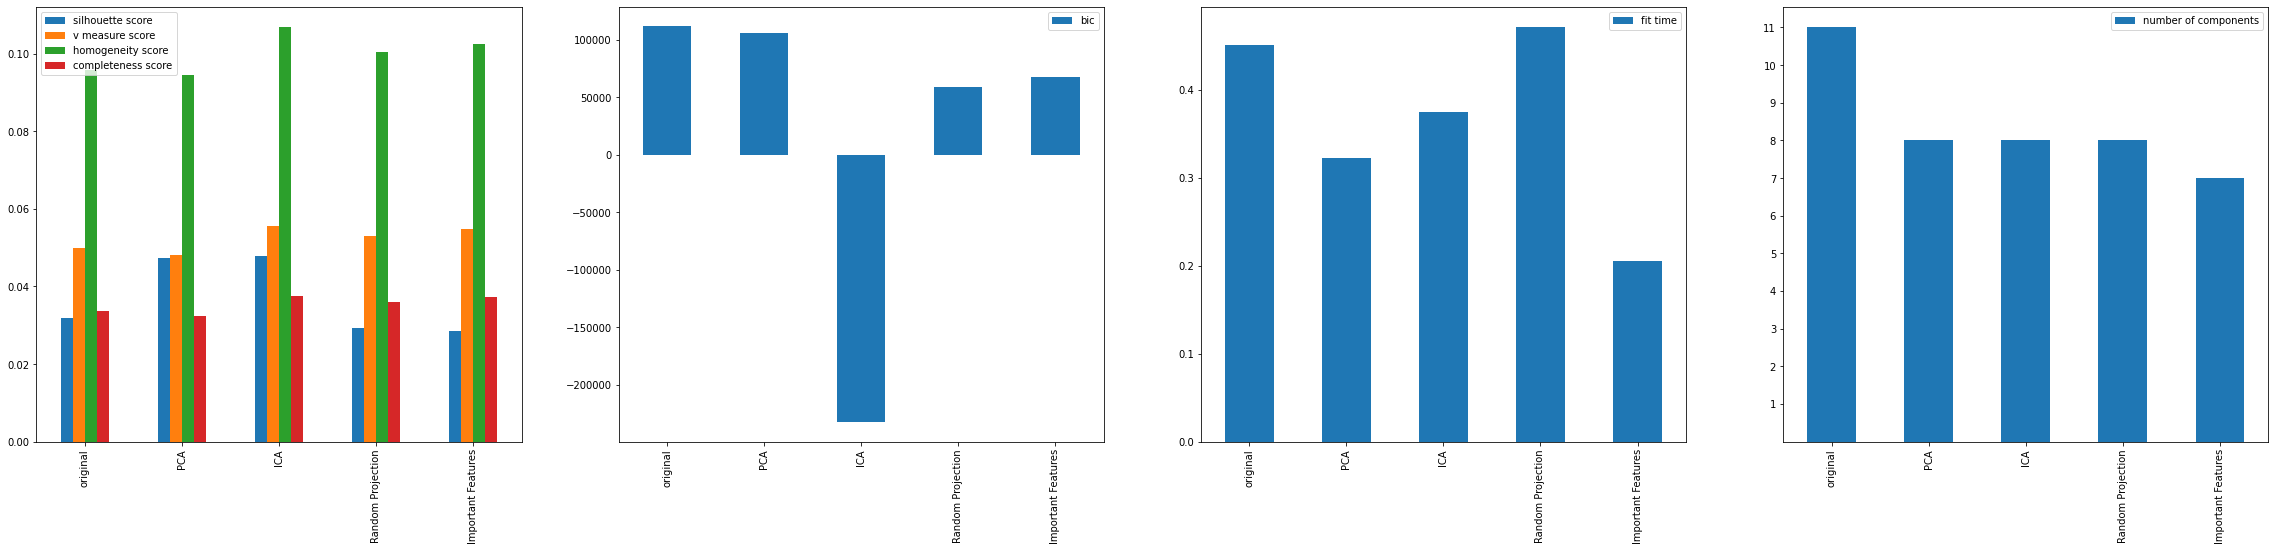

In [45]:

fig, ax = plt.subplots(1, 4, figsize=(40, 8))
em_metrics.plot.bar(y=['silhouette score', 'v measure score', 'homogeneity score', 'completeness score'], ax=ax[0])
em_metrics.plot.bar(y='bic', ax=ax[1])
em_metrics.plot.bar(y='fit time', ax=ax[2])
ax[3].set_yticks(range(1, em_metrics['number of components'].max() + 1))
em_metrics.plot.bar(y='number of components', ax=ax[3])
plt.show()

In [46]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

transformed_features_split = [
    train_test_split(transformed_features, wine_labels_2,
                     test_size=0.3, random_state=42)
    for transformed_features in transformed_features_list
]
accuracy_score_train = []
accuracy_score_test = []
fit_time = []
for (x_train, x_test, y_train, y_test) in transformed_features_split:
    neural_network = MLPClassifier(
        hidden_layer_sizes=(40, 80),
        alpha=0.001,
        learning_rate_init=0.01,
        max_iter=1000,
        random_state=42
    )
    t0 = time()
    neural_network.fit(x_train, y_train)
    fit_time.append(time() - t0)
    
    accuracy_score_train.append(accuracy_score(y_train, neural_network.predict(x_train)))
    accuracy_score_test.append(accuracy_score(y_test, neural_network.predict(x_test)))   


In [47]:
neural_network_metrics = pd.DataFrame(
    {
        'number of components': feature_count,
        'fit time': fit_time,
        'accuracy score (train)': accuracy_score_train,
        'accuracy score (test)': accuracy_score_test,
    },
    index=['original', 'PCA', 'ICA', 'Random Projection', 'Important Features'])
neural_network_metrics

,number of components,fit time,accuracy score (train),accuracy score (test)
original,11,3.161366,0.983372,0.803401
PCA,8,3.133279,0.946616,0.793197
ICA,8,4.519272,0.799300,0.763265
Random Projection,8,4.440344,0.948658,0.751020
Important Features,7,3.119396,0.946324,0.788435


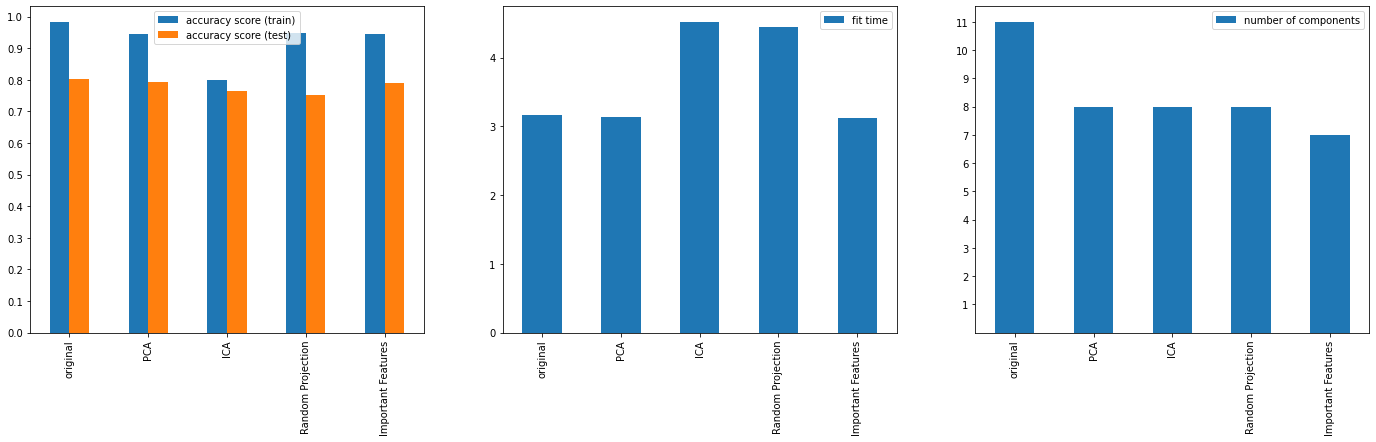

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
ax[0].set_yticks(np.arange(0.0, 1.1, 0.1))
neural_network_metrics.plot.bar(y=['accuracy score (train)', 'accuracy score (test)'], ax=ax[0])
neural_network_metrics.plot.bar(y='fit time', ax=ax[1])
ax[2].set_yticks(range(1, neural_network_metrics['number of components'].max() + 1))
neural_network_metrics.plot.bar(y='number of components', ax=ax[2])
plt.show()

In [49]:
transformed_features_list = [pd.DataFrame(transformed_features) for transformed_features in transformed_features_list]
for transformed_features, labels in zip(transformed_features_list, clustering_labels):
    transformed_features['k-means clustering labels'] = labels
transformed_features_list = [transformed_features.values for transformed_features in transformed_features_list]


In [50]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

transformed_features_split = [
    train_test_split(transformed_features, wine_labels_2,
                     test_size=0.3, random_state=42)
    for transformed_features in transformed_features_list
]
accuracy_score_train = []
accuracy_score_test = []
fit_time = []
for (x_train, x_test, y_train, y_test) in transformed_features_split:
    neural_network = MLPClassifier(
        hidden_layer_sizes=(40, 80),
        alpha=0.001,
        learning_rate_init=0.01,
        max_iter=1000,
        random_state=42
    )
    t0 = time()
    neural_network.fit(x_train, y_train)
    fit_time.append(time() - t0)
    
    accuracy_score_train.append(accuracy_score(y_train, neural_network.predict(x_train)))
    accuracy_score_test.append(accuracy_score(y_test, neural_network.predict(x_test)))  

In [51]:
neural_network_with_labels_metrics = pd.DataFrame(
    {
        'number of components': feature_count,
        'fit time': fit_time,
        'accuracy score (train)': accuracy_score_train,
        'accuracy score (test)': accuracy_score_test,
    },
    index=['original', 'PCA', 'ICA', 'Random Projection', 'Important Features'])
neural_network_with_labels_metrics

,number of components,fit time,accuracy score (train),accuracy score (test)
original,11,2.804946,0.974329,0.791837
PCA,8,2.367163,0.962077,0.796599
ICA,8,2.297146,0.775088,0.757143
Random Projection,8,3.007340,0.880397,0.729252
Important Features,7,2.270340,0.894107,0.770068


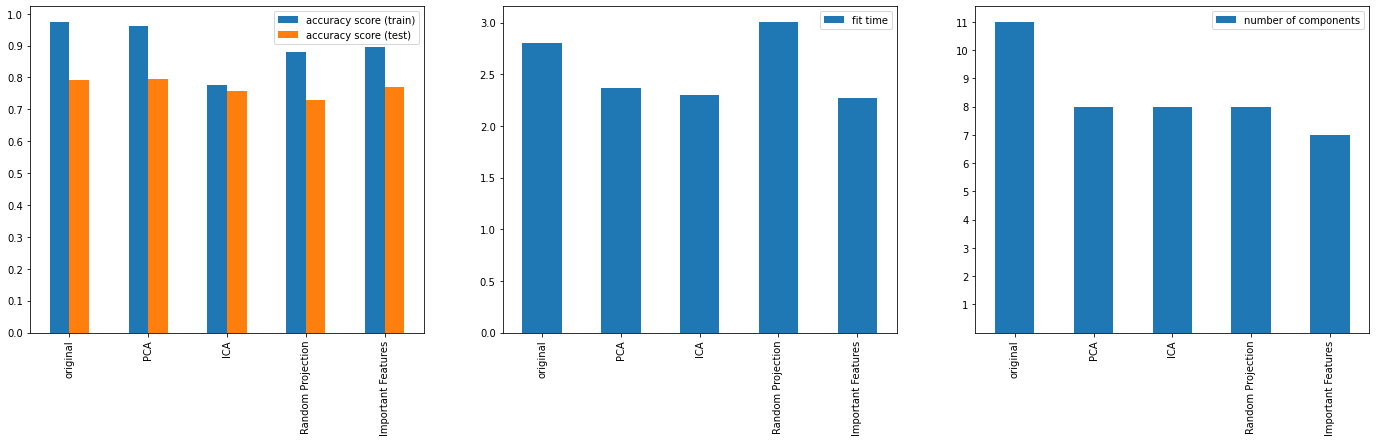

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
ax[0].set_yticks(np.arange(0.0, 1.1, 0.1))
neural_network_with_labels_metrics.plot.bar(y=['accuracy score (train)', 'accuracy score (test)'], ax=ax[0])
neural_network_with_labels_metrics.plot.bar(y='fit time', ax=ax[1])
ax[2].set_yticks(range(1, neural_network_metrics['number of components'].max() + 1))
neural_network_with_labels_metrics.plot.bar(y='number of components', ax=ax[2])
plt.show()

In [56]:
neural_network_comparison = pd.DataFrame(
    {
        'fit time': neural_network_metrics['fit time'],
        'fit time - k-means labels': neural_network_with_labels_metrics['fit time'],
        'accuracy score (train)': neural_network_metrics['accuracy score (train)'],
        'accuracy score (train) - EM labels': neural_network_with_labels_metrics['accuracy score (train)'],
        'accuracy score (test)': neural_network_metrics['accuracy score (test)'],
        'accuracy score (test) - EM labels': neural_network_with_labels_metrics['accuracy score (test)']
    },
    index=['original', 'PCA', 'ICA', 'Random Projection', 'Important Features']
)
neural_network_comparison


,fit time,fit time - k-means labels,accuracy score (train),accuracy score (train) - EM labels,accuracy score (test),accuracy score (test) - EM labels
original,3.161366,2.804946,0.983372,0.974329,0.803401,0.791837
PCA,3.133279,2.367163,0.946616,0.962077,0.793197,0.796599
ICA,4.519272,2.297146,0.799300,0.775088,0.763265,0.757143
Random Projection,4.440344,3.007340,0.948658,0.880397,0.751020,0.729252
Important Features,3.119396,2.270340,0.946324,0.894107,0.788435,0.770068


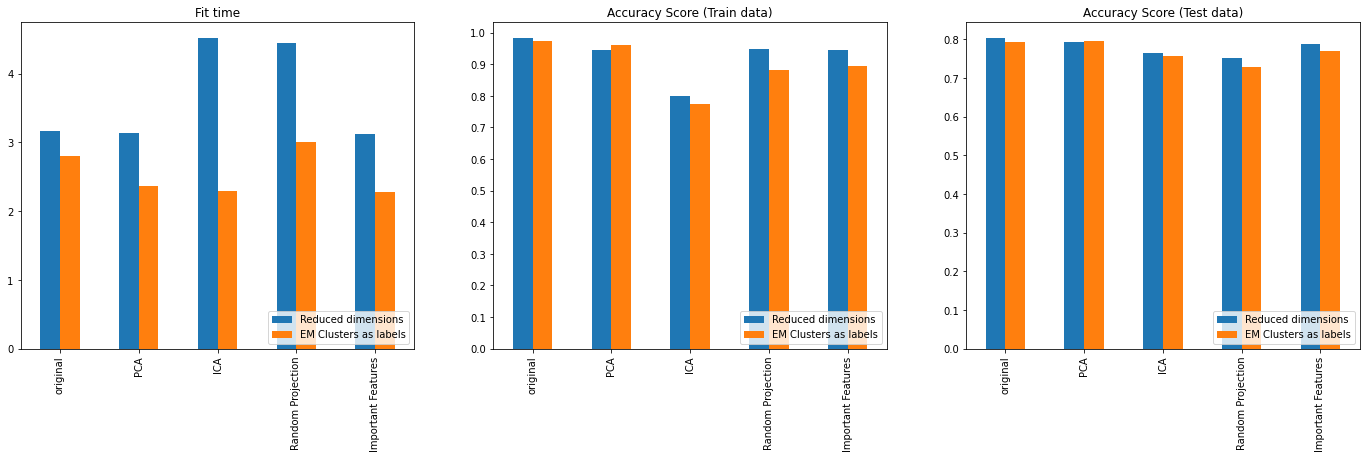

In [57]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
neural_network_comparison.plot.bar(y=['fit time', 'fit time - k-means labels'], ax=ax[0], title='Fit time')
ax[0].legend(['Reduced dimensions', 'EM Clusters as labels'], loc=4)
ax[1].set_yticks(np.arange(0.0, 1.1, 0.1))
neural_network_comparison.plot.bar(y=['accuracy score (train)', 'accuracy score (train) - EM labels'], ax=ax[1], title='Accuracy Score (Train data)')
ax[1].legend(['Reduced dimensions', 'EM Clusters as labels'], loc=4)
ax[2].set_yticks(np.arange(0.0, 1.1, 0.1))
neural_network_comparison.plot.bar(y=['accuracy score (test)', 'accuracy score (test) - EM labels'], ax=ax[2], title='Accuracy Score (Test data)')
ax[2].legend(['Reduced dimensions', 'EM Clusters as labels'], loc=4)
plt.show()

References:
- Arthur, D. and Vassilvitskii, S. “k-means++: the advantages of careful seeding: https://theory.stanford.edu/~sergei/papers/kMeansPP-soda.pdf